Для воспроизводимости кода установим определенную версию tensorflow и keras

In [17]:
!pip install -q tensorflow==2.1

ERROR: Could not find a version that satisfies the requirement tensorflow==2.1 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.19.0rc0)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for tensorflow==2.1


In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [19]:
print("We're using TF", tf.__version__)
print("We are using Keras", keras.__version__)

We're using TF 2.18.0
We are using Keras 3.7.0


In [20]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

''

In [21]:
#GPU count and name
!nvidia-smi -L

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [22]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


# MNIST

In [23]:
# скачиваем данные
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

In [24]:
# что за данные
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[5 0 4 1 9 2 1 3 1 4]
[7 2 1 0 4 1 4 9 5 9]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


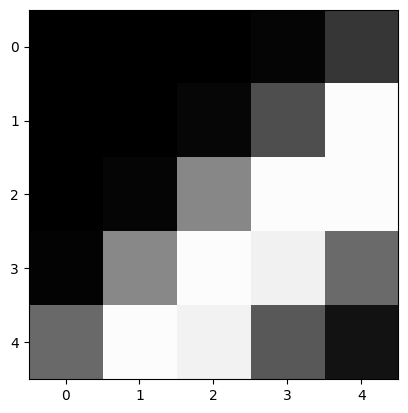

Пример картинки:


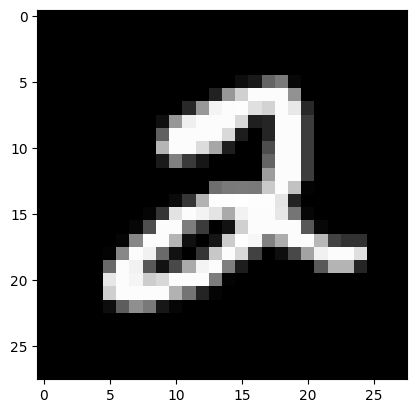

y_train [shape (60000,)] 10 примеров:
 [5 0 4 1 9 2 1 3 1 4]


In [25]:
# нарисуем картинку
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

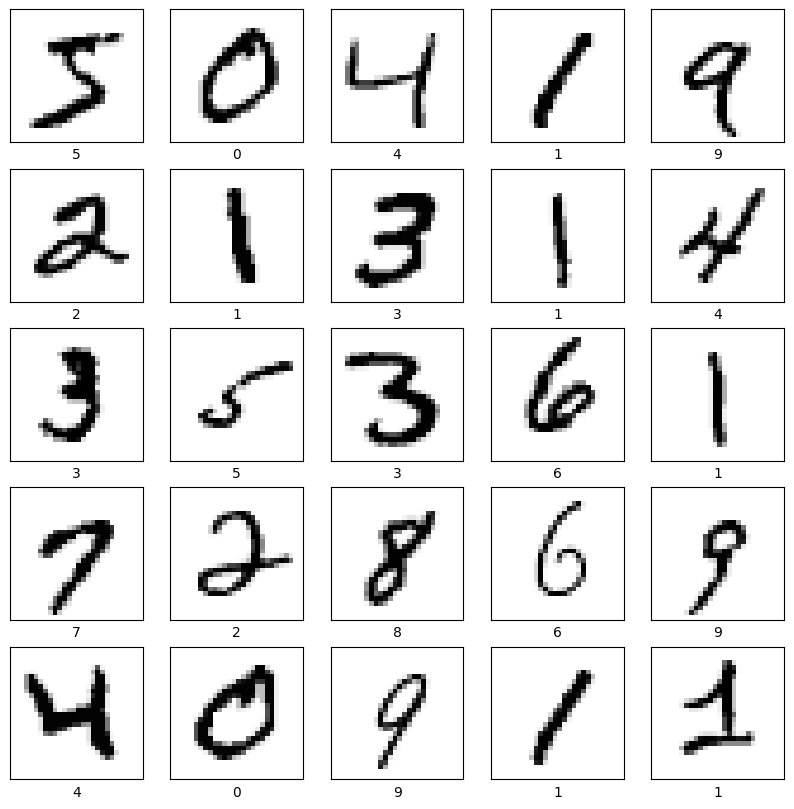

In [26]:
# Посмотрим побольше примеров
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap="Greys")
    plt.xlabel(y_train[i])
plt.show()

# Data

In [27]:
# вытянем картинку в вектор размера 28*28=784 и будем использовать это как фичи!

x_train_flat = x_train.reshape(-1, 28*28).astype(float)
print(x_train.shape, x_train_flat.shape)

x_val_flat = x_val.reshape(-1, 28*28).astype(float)
print(x_val.shape, x_val_flat.shape)

(60000, 28, 28) (60000, 784)
(10000, 28, 28) (10000, 784)


In [28]:
# центрируем и нормируем, так сети будет проще учиться
x_train_float = x_train_flat.astype(np.float64) / 255 - 0.5
x_val_float = x_val_flat.astype(np.float64) / 255 - 0.5

# по сути, это действия аналогичны нормализации через StandardScaler
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x_train_flat = scaler.fit_transform(x_train_flat)
# x_val_flat = scaler.transform(x_val_flat)

# Но попробуйте пропустить нормирование и посмотрите что будет ;)
# x_train_float = x_train_flat.astype(np.float)
# x_val_float = x_val_flat.astype(np.float)

In [29]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]] [5 0 4 1 9]


# Собираем модель

Построим простой Multi layer Perceptron (MLP) классификатор в Keras (по аналогии со знакомым нам уже MLPClassifier из sklearn)

<img src="https://cdn-images-1.medium.com/max/1600/1*Gh5PS4R_A5drl5ebd_gNrg@2x.png" width="500">


Сначала надо будет посчитать логиты (logit, линейное преобразование) $z_k$ для каждого класса: $$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

А затем превратить логиты $z_k$ в вероятности $p_k$ при помощи функции softmax: $$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

Мы будем использовать cross-entropy для минимизации ошибки: $$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$

где $$ [x]=\begin{cases} 1, \quad \text{если $x$ истина} \\ 0, \quad \text{иначе} \end{cases} $$

Минимизация cross-entropy двигает $p_k$ в сторону 1 когда $y = k$, что как раз мы и хотим.


In [30]:
clear_session()

In [31]:
# Архитектура сети
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(x_train_float.shape[1],))) # первый скрытый слой
model.add(Dense(128, activation='relu',)) # второй скрытый слой
model.add(Dense(10, activation='softmax',)) # выходной слой

c:\Projects\DS\lessons\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [34]:
history = model.fit(
                    x_train_float,
                    y_train_oh,
                    batch_size=64,  # 64 объекта для подсчета градиента на каждом шаге
                    epochs=10,  # 10 проходов по датасету
                    validation_data=(x_val_float, y_val_oh)
                    )

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.8426 - loss: 0.5226 - val_accuracy: 0.9507 - val_loss: 0.1593
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9524 - loss: 0.1530 - val_accuracy: 0.9641 - val_loss: 0.1110
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9650 - loss: 0.1093 - val_accuracy: 0.9652 - val_loss: 0.1137
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9739 - loss: 0.0823 - val_accuracy: 0.9720 - val_loss: 0.0939
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9774 - loss: 0.0698 - val_accuracy: 0.9763 - val_loss: 0.0806
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9793 - loss: 0.0644 - val_accuracy: 0.9716 - val_loss: 0.0911
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9824 - loss: 0.0532 - val_accuracy: 0.9750 - val_loss: 0.0876
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9837 - loss: 0.0495 - val_accuracy: 0

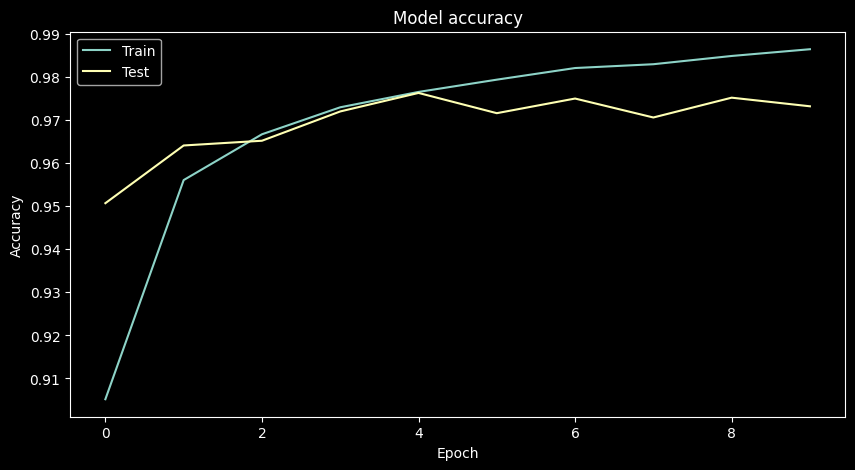

In [35]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

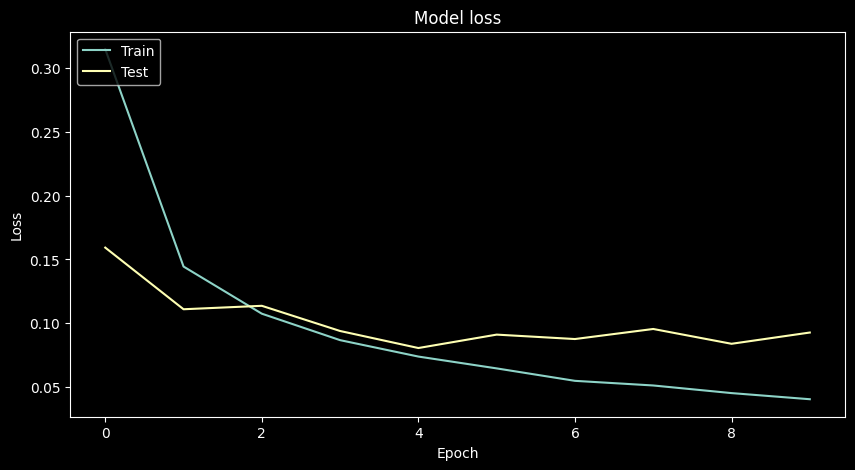

In [36]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [37]:
model.predict(x_val_float)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


array([[1.4696745e-09, 4.1159041e-09, 9.5326010e-07, ..., 9.9998236e-01,
        3.6065642e-09, 6.0161942e-06],
       [4.6368816e-12, 5.6805216e-12, 1.0000000e+00, ..., 1.6016151e-14,
        1.6452080e-09, 2.4675939e-16],
       [1.2238755e-06, 9.9099332e-01, 5.8104984e-06, ..., 8.7437071e-03,
        7.7285877e-05, 4.2528292e-05],
       ...,
       [3.3467600e-13, 1.0153472e-12, 4.4245740e-15, ..., 1.4449581e-07,
        3.3577111e-10, 8.6036216e-06],
       [4.2940336e-08, 1.9243068e-13, 2.4146362e-12, ..., 4.3673967e-09,
        8.3944389e-07, 1.0972542e-11],
       [1.4881740e-13, 2.7028522e-17, 1.1038711e-16, ..., 1.1681829e-14,
        6.7340292e-14, 1.0145943e-10]], dtype=float32)

In [38]:
model.predict_classes(x_val_float)

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [ ]:
# аналогично
np.argmax(model.predict(x_val_float), axis = 1)

array([7, 2, 1, ..., 4, 5, 6])

In [ ]:
predicts = model.predict_classes(x_val_float)
print('Test Accuracy: ', accuracy_score(y_val, predicts))

Test Accuracy:  0.9795
